#Previsione Livelli Ricoveri Terapia Intensiva, Nuovi Positivi e Deceduti per COVID

Nel seguente notebook sono stati utilizzati tre diversi modelli, LSTM, XGBoost e ARIMA con i dati resi disponibili dal Ministero della Salute per effettuare un forecast con orizzonte 1, 2, 7 e 14 giorni dei valori considerati.

Sono stati usati i dati regionali resi disponibili via file .csv al [link](https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv) e filtrati per regione di interesse, in questo caso Emilia-Romagna.
Ogni riga è un aggiornamento giornaliero dei seguenti valori: 
data, stato, codice_regione, denominazione_regione, lat, long, ricoverati_con_sintomi, terapia_intensiva,totale_ospedalizzati, isolamento_domiciliare, totale_positivi, variazione_totale_positivi, nuovi_positivi, dimessi_guariti, deceduti, casi_da_sospetto_diagnostico, casi_da_screening, totale_casi, tamponi, casi_testati, note, ingressi_terapia_intensiva, note_test, note_casi, totale_positivi_test_molecolare, totale_positivi_test_antigenico_rapido, tamponi_test_molecolare, tamponi_test_antigenico_rapido, codice_nuts_1, codice_nuts_2. 

Di questi sono state poi utilizzate per l'analisi: 
data, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati variazione_totale_positivi, nuovi_positivi, deceduti, 'tamponi' ingressi_terapia_intensiva.

I valori di deceduti e tamponi sono stati differenziati per avere l'incremento giornaliero invece del dato cumulativo che era presente.

L'analisi svolta è su singola variabile.

I dati sono stati divisi con percentuale di 80 e 20 rispettivamente per training e testing.

Il primo 80% di dati in fase di tuning è a sua volta divisa in 80% di train e 20% di validation, in modo che il tuning non viene effettuato su dati di test.

Dopo la suddivisione è stato effettuato lo scaling attravero un MinMaxScaler che comprime i valori tra -1 ed 1 (la trasformazione viene poi invertita dopo la previsione).

Per i modelli XGBoost e LSTM sono stati preparati i dati creando per ogni giorno un array di lag temporali e di valori futuri della variabile presa in considerazione:
(t-n,...,t-1,t) -> (t+1,...,t+p) con n = giorni di lag e p = orizzonte di previsione.
Questi valori sono stati utilizzati per il training dei due modelli utilizzando le variabili lag come ingresso del modello e i valori futuri come target.

Con ARIMA per ogni giorno la previsione degli n giorni successivi è stata calcolata fornendo al modello i dati presenti fino a quel momento. Il modello scelto per ARIMA è con (p,q,d) = (10,1,1)

L'errore considerato è il Mean Absolute Error sull'orizzonte di previsione. Viene poi considerata la media dei MAE calcolati su tutte le previsioni.

Gli hyperparameters sono stati scelti attraverso una grid search per ogni variabile e per ogni orizzonte temporale selezionando il modello che da una media degli errori inferiore.

Il grafico mostra lo slot temporale di previsione con MAE inferiore.


In [33]:
import os

if 'google.colab' in str(get_ipython()):
    files = ['util.py',
             'windows.py',
             'models']

    for file in files:
        os.system('rm ./' + file)
        os.system(
            'wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/' + file)

import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.multioutput import MultiOutputRegressor
from numpy.random import seed
import plotly.graph_objects as go

# fix for 'package not found' when installing in Anaconda environment
if 'google.colab' not in str(get_ipython()):
    import pip
    pip.main(['install', 'xgboost'])

import xgboost as xgb
from xgboost import XGBRegressor
from util import select_relevant_rows, select_attributes, read_movement_data, download_updated_mobility_data, download_updated_mobility_data, series_to_supervised, split_dates, save_config, load_config, plot_graphs


In [34]:
use_existing_config = True
column_to_predict = 'terapia_intensiva'
columns = ['nuovi_positivi', 'terapia_intensiva', 'deceduti']
split_percent = 0.80
region_focus = 'Emilia-Romagna'
attribute_focus = 'denominazione_regione'
n_futures = [1, 2, 7, 14]

In [35]:
local_region_path = r'../COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv'
remote_region_path = r'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'

regions_frame = pd.read_csv(remote_region_path)

region_focus_data = select_relevant_rows(
    regions_frame,
    attribute_focus,
    region_focus
)

frame_interesting_columns = select_attributes(region_focus_data, [
    'data',
    'ricoverati_con_sintomi',
    'terapia_intensiva',
    'totale_ospedalizzati',
    'variazione_totale_positivi',
    'nuovi_positivi',
    'deceduti',
    'tamponi',
    'ingressi_terapia_intensiva'
])

frame_interesting_columns = pd.DataFrame(frame_interesting_columns)
frame_interesting_columns['data'] = pd.to_datetime(
    frame_interesting_columns['data'])
frame_interesting_columns['data'] = frame_interesting_columns['data'].dt.strftime(
    r'%Y-%m-%d')
frame_interesting_columns = frame_interesting_columns.fillna(0)

mobility_data_url = r'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
file_path = r'../Global_Mobility_Report.csv'
mobility_data_zip_url = r'https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip'
zip_path = r'../Region_Mobility_Report_CSVs.zip'
region_mobility_path = r'../Region_Mobility_Report_CSVs'

download_updated_mobility_data(
    mobility_data_url,
    file_path,
    region_mobility_path,
    mobility_data_zip_url,
    zip_path
)

mobility_df = read_movement_data(
    region_mobility_path,
    'IT_Region_Mobility_Report',
    region='Emilia-Romagna'
)

mobility_df = mobility_df[['date',
                           'retail_and_recreation_percent_change_from_baseline',
                           'grocery_and_pharmacy_percent_change_from_baseline',
                           'parks_percent_change_from_baseline',
                           'transit_stations_percent_change_from_baseline',
                           'workplaces_percent_change_from_baseline',
                           'residential_percent_change_from_baseline']].fillna(0)

frame_interesting_columns.rename(columns={'data': 'date'}, inplace=True)
frame_interesting_columns.set_index('date', inplace=True)
mobility_df.set_index('date', inplace=True)

# revert cumulative data
frame_interesting_columns['deceduti'] = frame_interesting_columns['deceduti'].diff(
)
frame_interesting_columns['tamponi'] = frame_interesting_columns['tamponi'].diff(
)
frame_interesting_columns.dropna(inplace=True)

merged = pd.merge(
    frame_interesting_columns,
    mobility_df,
    on='date'
)

merged = merged.fillna(0)
merged.set_index(pd.DatetimeIndex(merged.index), inplace=True)

# numpy seed
seed(1)

Data already up to date...


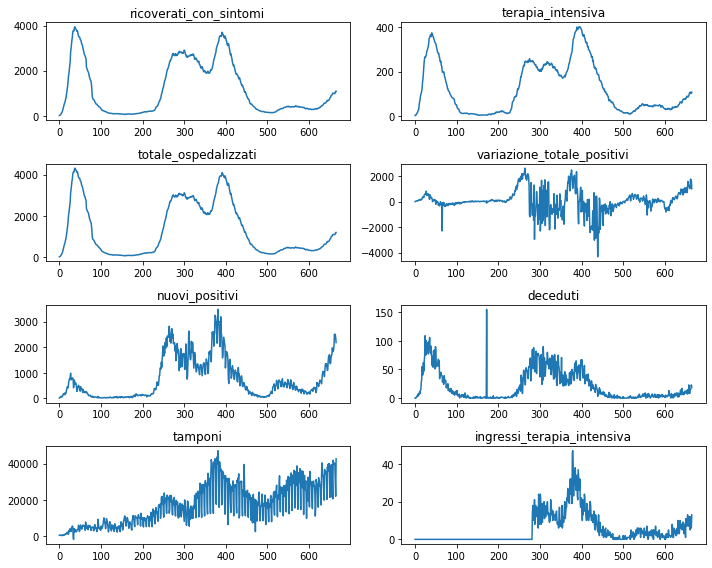

In [36]:
fig, axes = pyplot.subplots(nrows=4, ncols=2, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    data = np.array(
        frame_interesting_columns[frame_interesting_columns.columns[i]])
    ax.plot(pd.DataFrame(data))
    ax.set_title(frame_interesting_columns.columns[i])
    ax.plot()

pyplot.tight_layout()

In [37]:
def split_series(series, n_past, n_future, arima=False):
    X, y, X_indexes, y_indexes = list(), list(), list(), list()
    index = np.array(series.index).reshape(series.values.shape[0], 1)
    series = series.values

    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        start = 0 if arima == True else window_start

        past, future = series[start:past_end,
                              :], series[past_end:future_end, :]
        past_index, future_index = index[start:past_end,
                                         :], index[past_end:future_end, :]
        X.append(past)
        y.append(future)
        X_indexes.append(past_index)
        y_indexes.append(future_index)

    return np.array(X), np.array(y), np.array(X_indexes), np.array(y_indexes)


def plot_best_pred(
    sorted_results, column_to_predict):
        pred = sorted_results[0][1][1]['pred']
        test = sorted_results[0][1][1]['y_test']

        prediction_trace = go.Scatter(
            x=pred.index, y=pred, mode='lines', name='Prediction')
        truth_trace = go.Scatter(
            x=test.index, y=test, mode='lines', name='Ground Truth')
        layout = go.Layout(
            title=column_to_predict, xaxis={'title': 'Date'},
            yaxis={'title': column_to_predict})
        fig = go.Figure(
            data=[prediction_trace, truth_trace], layout=layout)
        fig.show()

#LSTM Multi Output 

In [38]:
def define_compile_lstm(config, input_shape, n_future=7):
    model = Sequential()
    model.add(LSTM(config['input'], activation=config['activation'],
                   input_shape=input_shape, return_sequences=True))
    model.add(LSTM(config['hidden'], activation=config['activation'],
                   return_sequences=False))
    model.add(Dropout(config['dropout']))
    model.add(Dense(n_future))
    model.compile(optimizer=config['optimizer'], loss=config['loss'])
    return model


def define_lstm_configs():
    input = [32, 64, 128]
    hidden = [32, 64, 128]
    activation = ['relu']
    dropout = [0.1, 0.2]
    out = [1]
    optimizer = ['adam']
    loss = ['mae']
    look_back = [28]

    configs = []
    keys = ['input', 'hidden', 'activation', 'dropout', 'out',
            'optimizer', 'loss', 'look_back']

    for i in input:
        for j in hidden:
            for k in activation:
                for l in dropout:
                    for m in out:
                        for n in optimizer:
                            for o in loss:
                                for p in look_back:
                                        config = dict(
                                            zip(keys, (i, j, k, l, m, n, o, p)))
                                        configs.append(config)

    return configs


def execute_lstm(
        dataframe, column_to_predict, config, split_percent=0.80, multi=False, n_future=7):
    df = dataframe[column_to_predict].copy()

    split = int(split_percent*len(df))

    n_past = config['look_back']
    n_features = 1

    train, test = pd.DataFrame(df[:split]), pd.DataFrame(df[split:])

    scalers = {}

    for i in train.columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        train[i] = s_s

    for i in test.columns:
        scaler = scalers['scaler_'+i]
        s_s = scaler.transform(test[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_'+i] = scaler
        test[i] = s_s

    X_train, y_train, X_train_indexes, y_train_indexes = split_series(
        train, n_past, n_future)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

    X_test, y_test, X_test_indexes, y_test_indexes = split_series(
        test, n_past, n_future)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

    model = define_compile_lstm(config, input_shape=(n_past,n_features), n_future=n_future)

    history = model.fit(
        X_train, y_train, epochs=50, validation_data=(X_test, y_test),
        verbose=0, shuffle=False)

    pred = model.predict(X_test)

    pred = pred.reshape(pred.shape[0], pred.shape[1], 1)

    for index, i in enumerate(train.columns):
        scaler = scalers['scaler_'+i]

        pred[:, :, index] = scaler.inverse_transform(pred[:, :, index])

        y_train[:, :, index] = scaler.inverse_transform(y_train[:, :, index])
        y_test[:, :, index] = scaler.inverse_transform(y_test[:, :, index])

    df_results = []

    for i in range(len(y_test)):
        current = pd.DataFrame(
            {'y_test':y_test[i].reshape(-1),
            'pred':pred[i].reshape(-1),
            'dates':y_test_indexes[i].reshape(-1)})
        current.set_index('dates', inplace=True)
        df_results.append(current)

    results = {}

    for el in df_results:
        error = mean_absolute_error(el['y_test'], el['pred'])
        results[el.index[0]] = (error, el)

    sorted_results = sorted(results.items(), key=lambda x: x[1][0])

    return sorted_results


def grid_search_lstm(
        dataframe, column_to_predict, split_percent=0.80, multi=False, n_future=7):
    configs = define_lstm_configs()
    results = []

    split = int(split_percent*len(dataframe))
    df_val = dataframe[:split].copy()

    for config in configs:
        sorted_results = execute_lstm(
            df_val, column_to_predict, config, split_percent=split_percent,
            multi=multi, n_future=n_future)

        results.append((np.mean(np.array(list(map(lambda x:x[1][0], sorted_results)))), config))

    return results


for n_future in n_futures:
    for column_to_predict in columns:
        config_path = region_focus + '_' + 'uni_lstm_config' + '_' + column_to_predict
        config_path = config_path + '_' + str(n_future)
        if use_existing_config:
            if not os.path.isfile(config_path):
                os.system('wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/configs/' + config_path)
            config = load_config(config_path)
            sorted_results = execute_lstm(
                frame_interesting_columns, column_to_predict=column_to_predict,
                config=config, split_percent=split_percent, multi=False, n_future=n_future)
            os.system('rm ' + config_path)
        else:
            results = grid_search_lstm(
                frame_interesting_columns, column_to_predict, split_percent=split_percent,
                multi=False, n_future=n_future)

            results.sort()
            config = results[0][-1]

            save_config(config_path, config)

            sorted_results = execute_lstm(
                frame_interesting_columns, column_to_predict=column_to_predict,
                config=config, split_percent=split_percent, multi=False, n_future=n_future)

        print('Value: ' + column_to_predict + ', n_future: ' + str(n_future))
        print('Best Config')
        print(config)

        print(('Best MAE: ', sorted_results[0][1][0]))
        print(('Average MAE: ', np.mean(np.array(list(map(lambda x:x[1][0], sorted_results))))))

        if n_future > 2:
            plot_best_pred(sorted_results, column_to_predict)
        else:
            print(('Pred: ', sorted_results[0][1][1]['pred'].values))
            print(('Test: ', sorted_results[0][1][1]['y_test'].values))


Value: nuovi_positivi, n_future: 1
Best Config
{'input': 32, 'hidden': 32, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 0.035400390625227374)
('Average MAE: ', 118.9436990989829)
('Pred: ', array([1844.9646], dtype=float32))
('Test: ', array([1845.]))
Value: terapia_intensiva, n_future: 1
Best Config
{'input': 64, 'hidden': 64, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 0.060638427734375)
('Average MAE: ', 4.366531713953556)
('Pred: ', array([75.06064], dtype=float32))
('Test: ', array([75.]))
Value: deceduti, n_future: 1
Best Config
{'input': 32, 'hidden': 32, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 0.03902244567871005)
('Average MAE: ', 3.1878769802597344)
('Pred: ', array([7.0390224], dtype=float32))
('Test: ', array([7.]))
Value: nuovi_positivi, n_future: 2
Best Con

Value: terapia_intensiva, n_future: 7
Best Config
{'input': 128, 'hidden': 64, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 1.954643794468471)
('Average MAE: ', 11.091259359632218)


Value: deceduti, n_future: 7
Best Config
{'input': 32, 'hidden': 64, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 1.0152098451341904)
('Average MAE: ', 2.5158020937442784)


Value: nuovi_positivi, n_future: 14
Best Config
{'input': 32, 'hidden': 64, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 48.71702793666293)
('Average MAE: ', 156.96573519377117)


Value: terapia_intensiva, n_future: 14
Best Config
{'input': 32, 'hidden': 128, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 5.952289581298831)
('Average MAE: ', 13.17066460417529)


Value: deceduti, n_future: 14
Best Config
{'input': 32, 'hidden': 128, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 3.4964400018964494)
('Average MAE: ', 6.220668441139608)


#XGBoost Multi Output

In [42]:
def define_xgb_configs():
    max_depth = [3, 6, 10]
    learning_rate = [0.01, 0.05, 0.1]
    n_estimators = [50, 100, 500, 1000]
    colsample_bytree = [0.3, 0.7]
    look_back = [28]
    objectives = ['reg:squarederror']

    configs = []
    keys = ['max_depth', 'learning_rate', 'n_estimators', 'colsample_bytree',
            'look_back', 'objective']

    for i in max_depth:
        for j in learning_rate:
            for k in n_estimators:
                for l in colsample_bytree:
                    for m in look_back:
                            for n in objectives:
                                config = dict(
                                    zip(keys, (i, j, k, l, m, n)))
                            configs.append(config)

    return configs


def execute_xgb(
        dataframe, column_to_predict, config, split_percent=0.80, n_future=7, multi=False):
    df = dataframe[column_to_predict].copy()
    split = int(split_percent*len(df))

    n_past = config['look_back']
    n_features = 1

    train, test = pd.DataFrame(df[:split]), pd.DataFrame(df[split:])

    scalers = {}

    for i in train.columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        train[i] = s_s

    for i in test.columns:
        scaler = scalers['scaler_'+i]
        s_s = scaler.transform(test[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_'+i] = scaler
        test[i] = s_s

    X_train, y_train, X_train_indexes, y_train_indexes = split_series(
        train, n_past, n_future)

    X_test, y_test, X_test_indexes, y_test_indexes = split_series(
        test, n_past, n_future)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
    X_train_indexes = X_train_indexes.reshape(
        X_train_indexes.shape[0], X_train_indexes.shape[1])
    y_train_indexes = y_train_indexes.reshape(
        y_train_indexes.shape[0], y_train_indexes.shape[1])

    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
    X_test_indexes = X_test_indexes.reshape(
        X_test_indexes.shape[0], X_test_indexes.shape[1])
    y_test_indexes = y_test_indexes.reshape(
        y_test_indexes.shape[0], y_test_indexes.shape[1])

    model = define_xgb(config)
    warnings.filterwarnings(action='ignore', category=UserWarning)
    model.fit(X_train, y_train)

    prediction = model.predict(X_test)  

    prediction[:, :] = scaler.inverse_transform(prediction[:, :])
    y_test[:, :] = scaler.inverse_transform(y_test[:, :])

    df_results = []

    for i in range(len(y_test)):
        current = pd.DataFrame(
            {'y_test':y_test[i].reshape(-1),
            'pred':prediction[i].reshape(-1),
            'dates':y_test_indexes[i].reshape(-1)})
        current.set_index('dates', inplace=True)
        df_results.append(current)

    results = {}

    for el in df_results:
        error = mean_absolute_error(el['y_test'], el['pred'])
        results[el.index[0]] = (error, el)

    sorted_results = sorted(results.items(), key=lambda x: x[1][0])

    return sorted_results


def grid_search_xgb(
        dataframe, column_to_predict, split_percent=0.80, n_future=7, multi=False):
    configs = define_xgb_configs()
    results = []

    split = int(split_percent*len(dataframe))
    df_val = dataframe[:split].copy()

    for config in configs:
        sorted_results = execute_xgb(
            df_val, column_to_predict, config, split_percent=split_percent,
            multi=multi, n_future=n_future)

        results.append((np.mean(np.array(list(map(lambda x:x[1][0], sorted_results)))), config))

    return results


def define_xgb(config):
    return MultiOutputRegressor(XGBRegressor(**config, verbosity=0))


for n_future in n_futures:
    for column_to_predict in columns:
        config_path = region_focus + '_' + 'uni_xgb_config' + '_' + column_to_predict
        config_path = config_path + '_' + str(n_future)
        if use_existing_config:
            if not os.path.isfile(config_path):
                os.system('wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/configs/' + config_path)
            config = load_config(config_path)
            sorted_results = execute_xgb(
                frame_interesting_columns, split_percent=split_percent, config=config,
                column_to_predict=column_to_predict, multi=False, n_future=n_future)
            os.system('rm ' + config_path)
        else:
            results = grid_search_xgb(
                frame_interesting_columns, split_percent=split_percent,
                column_to_predict=column_to_predict, multi=False)

            results.sort(key=lambda tup: tup[0])

            config = results[0][-1]

            save_config(config_path, config)

            sorted_results = execute_xgb(
                frame_interesting_columns, split_percent=split_percent, config=config,
                column_to_predict=column_to_predict, multi=False, n_future=n_future)

        print('Value: ' + column_to_predict + ', n_future: ' + str(n_future))
        print('Best Config')
        print(config)

        print(('Best MAE: ', sorted_results[0][1][0]))
        print(('Average MAE: ', np.mean(np.array(list(map(lambda x:x[1][0], sorted_results))))))

        if n_future > 2:
            plot_best_pred(sorted_results, column_to_predict)
        else:
            print(('Pred: ', sorted_results[0][1][1]['pred'].values))
            print(('Test: ', sorted_results[0][1][1]['y_test'].values))


Value: nuovi_positivi, n_future: 1
Best Config
{'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 1000, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 0.5687255859373863)
('Average MAE: ', 74.04587396585715)
('Pred: ', array([270.56873], dtype=float32))
('Test: ', array([270.]))
Value: terapia_intensiva, n_future: 1
Best Config
{'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 50, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 0.0023574829101491446)
('Average MAE: ', 3.216383862045577)
('Pred: ', array([32.002357], dtype=float32))
('Test: ', array([32.]))
Value: deceduti, n_future: 1
Best Config
{'max_depth': 10, 'learning_rate': 0.01, 'n_estimators': 1000, 'colsample_bytree': 0.3, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 0.020052433013920457)
('Average MAE: ', 2.7841646120233356)
('Pred: ', array([5.0200524], dtype=float32))
('Test: ', array([5.]))
Value: nuovi_posit

Value: terapia_intensiva, n_future: 7
Best Config
{'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 50, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 1.8938282557896227)
('Average MAE: ', 7.033996334075926)


Value: deceduti, n_future: 7
Best Config
{'max_depth': 10, 'learning_rate': 0.01, 'n_estimators': 1000, 'colsample_bytree': 0.3, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 1.1987465109143944)
('Average MAE: ', 3.30430146592004)


Value: nuovi_positivi, n_future: 14
Best Config
{'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 1000, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 27.147916521344865)
('Average MAE: ', 169.45277123517155)


Value: terapia_intensiva, n_future: 14
Best Config
{'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 50, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 2.961023330688476)
('Average MAE: ', 9.376217108900828)


Value: deceduti, n_future: 14
Best Config
{'max_depth': 10, 'learning_rate': 0.01, 'n_estimators': 1000, 'colsample_bytree': 0.3, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 1.624605451311385)
('Average MAE: ', 3.310206085626614)


#ARIMA Multi Output

In [43]:
def execute_arima(dataframe, order, column_to_predict, split_percent, n_future=7):
    df = dataframe[column_to_predict].copy()
    split = int(split_percent*len(df))

    n_past = 14
    n_features = 1

    train, test = pd.DataFrame(df[:split]), pd.DataFrame(df[split:])

    scalers = {}

    for i in train.columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        train[i] = s_s

    for i in test.columns:
        scaler = scalers['scaler_'+i]
        s_s = scaler.transform(test[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_'+i] = scaler
        test[i] = s_s

    X_train, y_train, X_train_indexes, y_train_indexes = split_series(
        train, n_past, n_future, arima=False)

    X_test, y_test, X_test_indexes, y_test_indexes = split_series(
        test, n_past, n_future, arima=False)
    
    df_results = []

    history = [x for x in train.values]

    for i in range(len(X_test)):
        current_history = np.array(history).reshape(-1)
        current_history = np.append(current_history, X_test[i].reshape(-1))

        model = ARIMA(current_history, order=order)
        model_fitted = model.fit()
        prediction = model_fitted.forecast(n_future)[0]

        prediction = scaler.inverse_transform(prediction.reshape(-1,1))
        y_test[i] = scaler.inverse_transform(y_test[i])

        current = pd.DataFrame(
            {'y_test':y_test[i].reshape(-1),
            'pred':prediction.reshape(-1),
            'dates':y_test_indexes[i].reshape(-1)})

        current.set_index('dates', inplace=True)
        
        df_results.append(current)

    results = {}

    for el in df_results:
        error = mean_absolute_error(el['y_test'], el['pred'])
        results[el.index[0]] = (error, el)

    sorted_results = sorted(results.items(), key=lambda x: x[1][0])

    return sorted_results


def define_arima_configs():
    p_values = [10]
    d_values = [1]
    q_values = [1]
    return p_values, d_values, q_values


def evaluate_models(dataframe, column_to_predict, split_percent, n_future=7):
    p_values, d_values, q_values = define_arima_configs()
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                sorted_results = execute_arima(
                    dataframe, order, column_to_predict, split_percent, n_future)
                avg_error = np.mean(
                    np.array(list(map(lambda x:x[1][0], sorted_results))))
                if avg_error < best_score:
                    best_score, best_cfg = avg_error, order
    return best_cfg


for n_future in n_futures:
    for column_to_predict in columns:
        config_path = region_focus + '_' + 'arima_config' + '_' + column_to_predict
        config_path = config_path + '_' + str(n_future)
        if use_existing_config:
            if not os.path.isfile(config_path):
                os.system('wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/configs/' + config_path)
            config = load_config(config_path)
            sorted_results = execute_arima(
                frame_interesting_columns, config, column_to_predict, split_percent, n_future=n_future)
            os.system('rm ' + config_path)
        else:
            config = evaluate_models(
                frame_interesting_columns, column_to_predict, split_percent)

            save_config(config_path, config)

            sorted_results = execute_arima(
                frame_interesting_columns, config, column_to_predict, split_percent, n_future=n_future)

        print('Value: ' + column_to_predict + ', n_future: ' + str(n_future))
        print(config)

        print(('Best MAE: ', sorted_results[0][1][0]))
        print(('Average MAE: ', np.mean(np.array(list(map(lambda x:x[1][0], sorted_results))))))

        if n_future > 2:
            plot_best_pred(sorted_results, column_to_predict)
        else:
            print(('Pred: ', sorted_results[0][1][1]['pred'].values))
            print(('Test: ', sorted_results[0][1][1]['y_test'].values))


Value: nuovi_positivi, n_future: 1
(10, 1, 1)
('Best MAE: ', 0.4993784300278321)
('Average MAE: ', 57.35784749927317)
('Pred: ', array([496.50062157]))
('Test: ', array([497.]))
Value: terapia_intensiva, n_future: 1
(10, 1, 1)
('Best MAE: ', 0.023180035427166956)
('Average MAE: ', 2.3045472192482164)
('Pred: ', array([39.97681996]))
('Test: ', array([40.]))
Value: deceduti, n_future: 1
(10, 1, 1)
('Best MAE: ', 0.04023679433387928)
('Average MAE: ', 2.4286496773478374)
('Pred: ', array([3.04023679]))
('Test: ', array([3.]))
Value: nuovi_positivi, n_future: 2
(10, 1, 1)
('Best MAE: ', 4.717034399218022)
('Average MAE: ', 65.7567603157719)
('Pred: ', array([163.29728238, 226.13678642]))
('Test: ', array([157., 223.]))
Value: terapia_intensiva, n_future: 2
(10, 1, 1)
('Best MAE: ', 0.06336989210355881)
('Average MAE: ', 2.8680619405470282)
('Pred: ', array([30.09637918, 30.0303606 ]))
('Test: ', array([30., 30.]))
Value: deceduti, n_future: 2
(10, 1, 1)
('Best MAE: ', 0.2500322525642318)


Value: terapia_intensiva, n_future: 7
(10, 1, 1)
('Best MAE: ', 1.0705374964319847)
('Average MAE: ', 4.736745534356568)


Value: deceduti, n_future: 7
(10, 1, 1)
('Best MAE: ', 0.9715893020521228)
('Average MAE: ', 2.5172586548003872)


Value: nuovi_positivi, n_future: 14
(10, 1, 1)
('Best MAE: ', 22.735365460947328)
('Average MAE: ', 114.44926522228829)


Value: terapia_intensiva, n_future: 14
(10, 1, 1)
('Best MAE: ', 1.5386597405288858)
('Average MAE: ', 6.864190753996499)


Value: deceduti, n_future: 14
(10, 1, 1)
('Best MAE: ', 1.2248329600235128)
('Average MAE: ', 2.4962556711552377)


##Risultati

###Deceduti
|    | LSTM                           | XGBoost                        | ARIMA                          |
|----|--------------------------------|--------------------------------|--------------------------------|
| 1  | Avg MAE: 3.18  <br />Best Slot: 0.03 | Avg MAE: 2.78  <br />Best Slot: 0.02 | Avg MAE: **2.42**  <br />Best Slot: 0.04 |
| 2  | Avg MAE: 4.03  <br />Best Slot: 0.33 | Avg MAE: 2.97  <br />Best Slot: 0.11 | Avg MAE: **2.44**  <br />Best Slot: 0.25 |
| 7  | Avg MAE: 2.51  <br />Best Slot: 1.01 | Avg MAE: 3.30  <br />Best Slot: 1.19 | Avg MAE: 2.51  <br />Best Slot: 0.97 |
| 14 | Avg MAE: 6.22  <br />Best Slot: 3.49 | Avg MAE: 3.31  <br />Best Slot: 1.62 | Avg MAE: **2.49**  <br />Best Slot: 1.22 |


###Terapia Intensiva
|    | LSTM                           | XGBoost                        | ARIMA                          |
|----|--------------------------------|--------------------------------|--------------------------------|
| 1  | Avg MAE: 3.18  <br />Best Slot: 0.03 | Avg MAE: 2.78  <br />Best Slot: 0.02 | Avg MAE: **2.42**  <br />Best Slot: 0.04 |
| 2  | Avg MAE: 4.03  <br />Best Slot: 0.33 | Avg MAE: 2.97  <br />Best Slot: 0.11 | Avg MAE: **2.44**  <br />Best Slot: 0.25 |
| 7  | Avg MAE: **2.51**  <br />Best Slot: 1.01 | Avg MAE: 3.30  <br />Best Slot: 1.19 | Avg MAE: **2.51**  <br />Best Slot: 0.97 |
| 14 | Avg MAE: 6.22  <br />Best Slot: 3.49 | Avg MAE: 3.31  <br />Best Slot: 1.62 | Avg MAE: **2.49**  <br />Best Slot: 1.22 |

###Nuovi Positivi
|    | LSTM                              | XGBoost                           | ARIMA                             |
|----|-----------------------------------|-----------------------------------|-----------------------------------|
| 1  | Avg MAE: 118.94  <br />Best Slot: 0.03  | Avg MAE: 74.04  <br />Best Slot: 0.56   | Avg MAE: **57.35**  <br />Best Slot: 0.49   |
| 2  | Avg MAE: 113.78  <br />Best Slot: 6.82  | Avg MAE: 88.25  <br />Best Slot: 6.17   | Avg MAE: **65.75**  <br />Best Slot: 4.71   |
| 7  | Avg MAE: 132.39  <br />Best Slot: 33.74 | Avg MAE: 113.55  <br />Best Slot: 28.43 | Avg MAE: **85.07**  <br />Best Slot: 16.29  |
| 14 | Avg MAE: 156.96  <br />Best Slot: 48.71 | Avg MAE: 169.45  <br />Best Slot: 27.14 | **Avg MAE: 114.49**  <br />Best Slot: 22.73 |

ARIMA mantiene un errore di previsione inferiore rispetto agli altri due modelli in tutti gli scenari tranne per l'orizzonte di 14 giorni giorni di terapia intensiva per cui LSTM ha un errore inferiore, e l'orizzonte terapia intensiva di 7 giorni in qui ARIMA ed LSTM hanno lo stesso MAE.
